<a href="https://colab.research.google.com/github/edberto/padi-back-python/blob/feature%2FPBP-5-edbert/rice_disease_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server

     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 3.3MB 80kB/s 


In [0]:
import os
import json
import tempfile
import requests
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub


In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [4]:
%cd ../tmp
%pwd

/tmp


'/tmp'

In [5]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [04:51<00:00, 52.3MB/s]
100% 12.0G/12.0G [04:51<00:00, 44.2MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133841.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133953.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_133956.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134124.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134125.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134126.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134128.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134129.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_20190424_134130.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2992.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2993.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2998.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_2999.jpg  
  inflating: LabelledRice/Labelled/BrownSpot/IMG_3017.jpg  
  inflatin

In [33]:
data_dir = '/tmp/LabelledRice/Labelled'

all_brown_spot = os.path.join(data_dir, 'BrownSpot')
all_healthy = os.path.join(data_dir, 'Healthy')
all_hispa = os.path.join(data_dir, 'Hispa')
all_leaf_blast = os.path.join(data_dir, 'LeafBlast')

print(len(os.listdir(all_brown_spot)))
print(len(os.listdir(all_healthy)))
print(len(os.listdir(all_hispa)))
print(len(os.listdir(all_leaf_blast)))

###############################################################333

base_dir = '/tmp/RiceDiseaseDataset'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

train_brown_spot = os.path.join(train_dir, 'BrownSpot')
train_healthy = os.path.join(train_dir, 'Healthy')
train_hispa = os.path.join(train_dir, 'Hispa')
train_leaf_blast = os.path.join(train_dir, 'LeafBlast')

val_brown_spot = os.path.join(val_dir, 'BrownSpot')
val_healthy = os.path.join(val_dir, 'Healthy')
val_hispa = os.path.join(val_dir, 'Hispa')
val_leaf_blast = os.path.join(val_dir, 'LeafBlast')

print(len(os.listdir(train_brown_spot)))
print(len(os.listdir(train_healthy)))
print(len(os.listdir(train_hispa)))
print(len(os.listdir(train_leaf_blast)))

print(len(os.listdir(val_brown_spot)))
print(len(os.listdir(val_healthy)))
print(len(os.listdir(val_hispa)))
print(len(os.listdir(val_leaf_blast)))

523
1488
565
779
400
400
400
400
123
123
123
123


In [43]:
datagen = ImageDataGenerator(rescale=1./255,                                  
                             rotation_range=40,
                            #  width_shift_range=0.2,
                            #  height_shift_range=0.2,
                            #  shear_range=0.2,
                            #  zoom_range=0.2,
                            #  horizontal_flip=True,
                            #  fill_mode='nearest',
                             validation_split=0.25)

training_gen = datagen.flow_from_directory(data_dir,
                                           batch_size=20,
                                           class_mode='categorical',
                                           target_size=(224, 224),
                                           subset='training')

validation_gen = datagen.flow_from_directory(data_dir,
                                             batch_size=20,
                                             class_mode='categorical',
                                             target_size=(224, 224),
                                             subset='validation')


#################################################################################3333

train_datagen = ImageDataGenerator(rescale=1./255,                                  
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size=10,
                                              class_mode='categorical',
                                              target_size=(224, 224))

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size=10,
                                          class_mode='categorical',
                                          target_size=(224, 224))

Found 2518 images belonging to 4 classes.
Found 837 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Found 492 images belonging to 4 classes.


In [53]:
classifier_url = 'https://tfhub.dev/google/imagenet/inception_v1/classification/4'

IMAGE_SHAPE=(224,224)

model = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = (224, 224, 3), trainable=False),
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2,2)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2,2)),
    # tf.keras.layers.Dropout(0.2),
    # # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # # tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
]) 

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_11 (KerasLayer)  (None, 1001)              6633209   
_________________________________________________________________
dense_19 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 2052      
Total params: 7,148,285
Trainable params: 515,076
Non-trainable params: 6,633,209
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [55]:
history = model.fit(training_gen, steps_per_epoch=40, epochs=8, validation_data=validation_gen, validation_steps=40, verbose=1)

Epoch 1/8
40/40 [==============================] - 169s 4s/step - loss: 2.5099 - accuracy: 0.4185 - val_loss: 1.9652 - val_accuracy: 0.4837
Epoch 2/8
40/40 [==============================] - 171s 4s/step - loss: 1.1434 - accuracy: 0.5652 - val_loss: 1.6007 - val_accuracy: 0.4425
Epoch 3/8
40/40 [==============================] - 171s 4s/step - loss: 1.0961 - accuracy: 0.5612 - val_loss: 1.4561 - val_accuracy: 0.5250
Epoch 4/8
40/40 [==============================] - 171s 4s/step - loss: 0.9412 - accuracy: 0.6250 - val_loss: 1.6299 - val_accuracy: 0.4712
Epoch 5/8
40/40 [==============================] - 172s 4s/step - loss: 1.0091 - accuracy: 0.5825 - val_loss: 1.4020 - val_accuracy: 0.5025
Epoch 6/8
40/40 [==============================] - 175s 4s/step - loss: 0.9762 - accuracy: 0.6103 - val_loss: 1.4143 - val_accuracy: 0.4238
Epoch 7/8
40/40 [==============================] - 173s 4s/step - loss: 0.8904 - accuracy: 0.6450 - val_loss: 1.3954 - val_accuracy: 0.5512
Epoch 8/8
40/40 [===

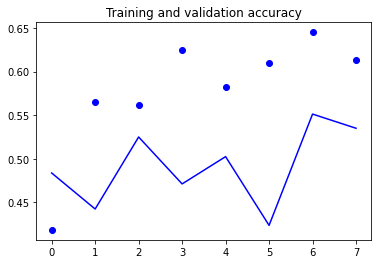

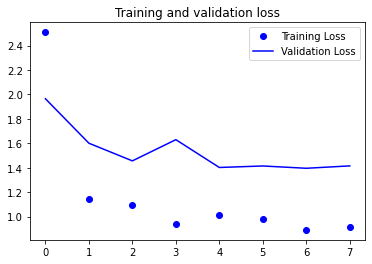

In [56]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=padi \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1